# Spiral Tip Detection Algorithm
Tim Tyree<br>
5.14.2020<br>

In [3]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show

import skimage as sk
from skimage import measure

#use cuda via numba
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from lib.contours_to_tips import *

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

from lib.minimal_model import *
from lib.get_tips import *
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


### Old spiral tip detection algorithm won't cut it
- is based on local pixel rules
- reports “false positive” spiral tips
- occasionally fails to detect a spiral tip
- writing spiral tip locations is very slow.

<img alt="" src="Figures/algorithm summary.png" style="height:650px;width:1480px" />

# skip these

### The new spiral tip detection algorithm
*in the 2D Euclidean domain with periodic boundary conditions*

 - Let $\mathcal{L}_{V = 0.3}$ (*grey curve*) be level set defined by $V = 0.3$ (in units where min voltage is zero and max voltage is one). 
 - Let $\mathcal{D}_\text{dV/dt>0}$ (*yellow curve*) be the 2D region where voltage is increasing, $dV/dt>0$.
 - Then the set of spiral tip locations $Q = \{\vec{x}_1, \vec{x}_2, \vec{x}_3, ..., \vec{x}_n\}$ is uniquely defined by
 
$$
Q = \mathcal{L}_{V = 0.3} \bigcap \partial\mathcal{D}_\text{dV/dt>0}
$$
 
Here we supposed that $\mathcal{L}_{V = 0.3}$ and $\mathcal{D}_\text{dV/dt>0}$ are finite collections of simply connected sets.



 - Let $\{c_i\}_{i\in I}$ denote the *linked lists* of contour points approximating the contours described by $\mathcal{L}_{V = 0.3}$.  using oriented *linked lists* of contour values using a *marching squares/marching triangles algorithm*.  , where $c_{i+1}$ denotes the next point on the contour and $c_{i-1}$ denote the previous point on the contour.
  - Let $\mathcal{D}_\text{increasing V}$ (*yellow curve*) be the 2D region where voltage is increasing, $dV/dt>0$.
 
 - note:which is 
         - parallelizable
         - produces continuous curve approximating the  boundary of a compact region 
     - let $\{c_i\}_{i\in I}$ be linked lists discretizing $\mathcal{L}$ that is returned by ^that marching squares algorithm
     - for each $c_i$, ask if both 


# contour detection by marching squares/triangles


# Limitation of current "quick and dirty" implementation of the new algorithm
- Current implementation of spiral tip detection is "quick and dirty".  It currently uses two nearby frames, and it is not parallelized.  
- Therefore rigorous accuracy benchmarking this version wouldn't tell us about how it handles edge cases.
- Nevertheless, an edge case is presented in the following slides.

# Import Example Data

In [2]:
data_dir = f"{nb_dir}/Data"
os.chdir(data_dir)

#ASSUMING the /mat/red colormap is in use
img_nxt_dir = 'sample002276.png'
img_prv_dir = 'sample002272.png'
img_nxt = sk.io.imread(img_nxt_dir, as_gray=False)
img_prv= sk.io.imread(img_prv_dir, as_gray=False)
os.chdir(nb_dir)

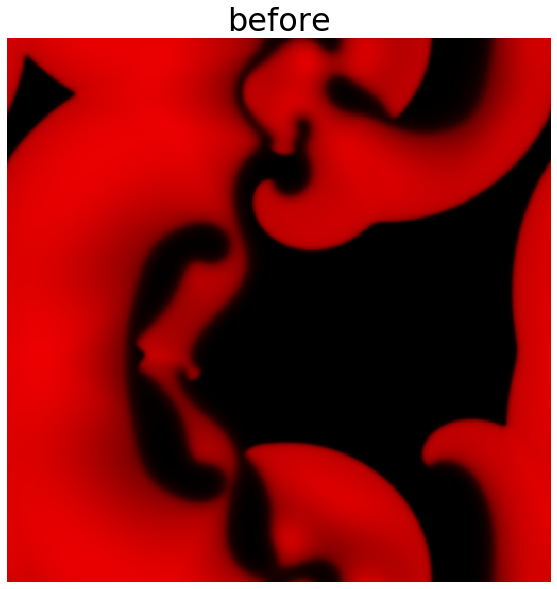

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(img_prv)
plt.title("before", fontsize=32)
plt.axis(False)
plt.show()

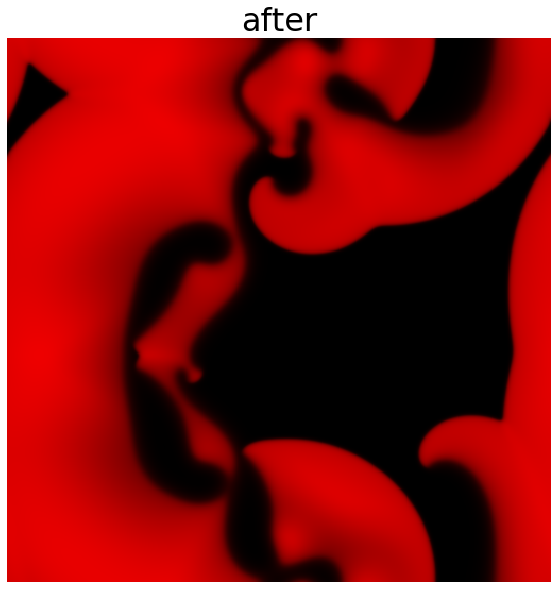

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(img_nxt)
plt.title("after", fontsize=32)
plt.axis(False)
plt.show()

### detect contours

In [5]:
# map an rgb from '/mat/red' cmap to it's scalar value between 0 and 1 by just selecting the red channel"""
image_nxt = img_nxt[:,:,0]/255
image_prv = img_prv[:,:,0]/255

In [6]:
#detect whether a pixel is increasing or decreasing.  
ifilter = np.vectorize(lambda x,x_old: 1. if x>x_old else 0.)
inc = ifilter(image_nxt,image_prv) #mask of increasing cells between a few frames

#get contours by a marching squares algorithm (which can be parallelized to increase performance in theory)
contours_raw = measure.find_contours(image_nxt, level=0.3, fully_connected='low', positive_orientation='low')
contours_edge = measure.find_contours(inc, 0.5)

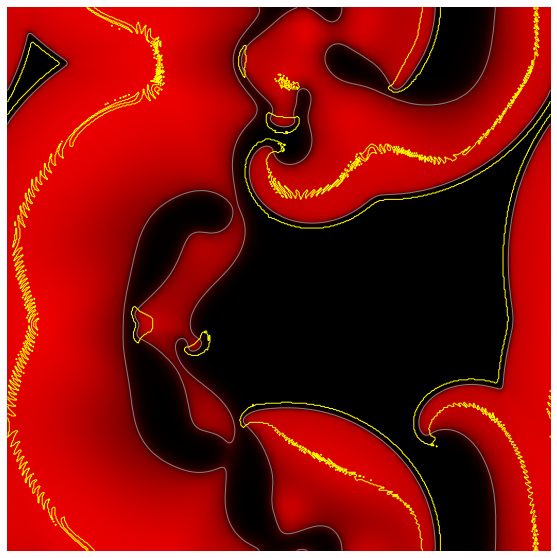

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(img_nxt)
for n, contour in enumerate(contours_raw):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, c='gray')
for n, contour in enumerate(contours_edge):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, c='yellow')
plt.axis(False)
plt.show()

# now compute the intersections by interpolating
<img alt="" src="Figures/marching_squares_linear_smoothing_example.png" style="height:700px;width:1200px" />


In [8]:
tips = contours_to_tips(contours_raw=contours_raw, 
                 contours_edge=contours_edge, 
                       inc = inc)
print(len(tips))

12


/Users/timothytyree/Documents/GitHub/care/notebooks/lib/contours_to_tips.py:12: RuntimeWarning: invalid value encountered in double_scalars
  a = SSxy/SSxx


In [9]:
tips

[(180.3400000000014, 312.15999999999866),
 (170.14973177658615, 319.4500894078046),
 (124.92190778160659, 311.77842515551606),
 (122.28807832792282, 283.7880783279228),
 (250.11143428650252, 135.72201310873365),
 (nan, nan),
 (248.90584893751515, 100.14496107721565),
 (223.5, 62.458250839933825),
 (224.51448070936001, 37.46062646086201),
 (360.78836633663315, 73.34282178217853),
 (398.0222222222277, 401.4281045751745),
 (224.32778028112722, 393.1722197188727)]

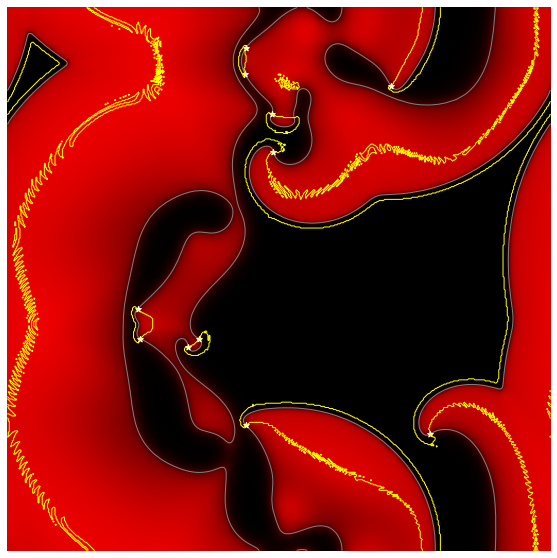

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(img_nxt)
[plt.scatter(x=x,y=y, c='w', zorder=2, marker='*') for x,y in tips]

for n, contour in enumerate(contours_raw):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, c='gray', zorder=1)
for n, contour in enumerate(contours_edge):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, c='yellow', zorder=2)
plt.axis(False)
plt.show()

Comparing to spiral tips detected on afig.ucsd.edu, the new algorithm catches two more spiral tips.
<img alt="" src="Figures/sample002276 web tips.png" style="height:512px;width:512px" />


Comparing to spiral tips detected on afig.ucsd.edu, the new algorithm catches two more spiral tips.
<img alt="" src="Figures/sample002276 web tips 2.png" style="height:512px;width:512px" />


### Consider 2D finite volumes, such as square pixels or triangular meshes
- let $\vec{x}_i$ be the location of a the $i^{th}$ finite volume
- $V(\vec{x}_i; t)$ be the voltage at the $i^{th}$ finite volume at time t.
- $\frac{d}{dt}V(\vec{x}_i; t)$ be the instantaneous rate of change of voltage at the $i^{th}$ finite volume at time t.
- let $\mathcal{N_i}$ be the set of finite volumes neighboring the $i^{th}$ finite volume.


# dev for measuring local spiral tip properties
8.2.2020

In [170]:
# #import dummy trajectories
# data_dir_log  = f"{nb_dir}/Data/ds_5_param_set_8/Log"
# data_fn_log = 'tip_log_ds_5_sigma_1.0_threshold_0.6_processed.csv'
# # data_fn_log = 'tip_log_ds_5_sigma_1.0_threshold_0.6_001.csv' #not terribly useful
# os.chdir(data_dir_log)
# df = pd.read_csv(data_fn_log)

# #example spiral tip location
# x,y = df.loc[5000][['x','y']]

In [148]:
#DONE: get texture values at the nearest pixel
#DONE: get texture values interpolated to the nearest pixel
#DONE: get neighboring pixel coordinates within a half pixel radius
#DONE: make a square array of pixel coordinates
#DONE: try sampling pixel values.  this means just ignore index out of range errors
#DONE: make a simple model of the pixel value interpolated to the present position. this relies on padding for edge cases
#DONE: make sure index out or range errors are properly ignored

#TODO(later): if not padding anymore
#TODO(later): map pixels to enforce periodic boundary conditions
#TODO(later): sample pixel values
#TODO(later): map pixel values back to original local xy coordinates

In [204]:
# from scipy.interpolate import interp2d
# #precompute the __padded__ coordinates
# xcoord_mesh, ycoord_mesh = np.meshgrid(np.arange(0,200),np.arange(0,200))

# x = 169.75099760896785
# y = 68.05364536542943

# #test retrieving value from coordinate textures matches the coordinates. (visual check used also.  not shown.)
# assert ( xcoord_mesh[yint,xint]==xint ) 
# assert ( ycoord_mesh[yint,xint]==yint ) 

In [ ]:
# texture = xcoord_mesh*ycoord_mesh

# local_values = texture[ylo:yhi+1,xlo:xhi+1]
# xcoord_local = xcoord_mesh[ylo:yhi+1,xlo:xhi+1]
# ycoord_local = ycoord_mesh[ylo:yhi+1,xlo:xhi+1]

In [228]:
# def get_state_nearest(x, y, txt):
#     '''nearest local texture values, ignore any index errors and/or periodic boundary conditions'''
#     xint = np.round(x).astype(dtype=int)
#     yint = np.round(y).astype(dtype=int)
#     try:
#         state_nearest = list(txt[xint,yint])
#     except IndexError:
#         state_nearest = nanstate
#     return state_nearest    

# def get_state_interpolated(x, y, txt, nanstate, xcoord_mesh, ycoord_mesh,
#                           channel_no = 3, rad = 0.5, kind='linear'):
#     '''linear interpolation of local texture values to subpixel precision
#     using 2D linear interpolation with scipy.interpolate.interp2d.
#     channel_no must be len(nanstate). 
#     for channel_no = 3, use nanstate = [np.nan,np.nan,np.nan].
#     rad = the pixel radius considered in interpolation.
#     kind can be "linear" or "cubic".  
#     if kind="cubic", then set rad = 3.5.'''
#     state_interpolated = nanstate #.copy() if you change nanstate to a numpy array
#     try:
#         xlo = np.round(x-rad).astype(dtype=int)
#         ylo = np.round(y-rad).astype(dtype=int)
#         xhi = np.round(x+rad).astype(dtype=int)
#         yhi = np.round(y+rad).astype(dtype=int)
#         yloc = ycoord_mesh[ylo:yhi+1,xlo:xhi+1].flatten().copy()
#         xloc = xcoord_mesh[ylo:yhi+1,xlo:xhi+1].flatten().copy()
#         local_values = txt[ylo:yhi+1,xlo:xhi+1]

#         interp_foo = lambda x,y,zloc: interp2d(yloc,xloc,zloc,kind=kind)(y,x)
#         for c in range(channel_no):
#             zloc = local_values[...,c].flatten().copy()
#             state_interpolated[c] = float(interp_foo(x,y,zloc))
#     except IndexError:
#         pass
#     return state_interpolated



In [229]:

# from scipy.interpolate import interp2d
# #precompute the __padded__ coordinates
# xcoord_mesh, ycoord_mesh = np.meshgrid(np.arange(0,200),np.arange(0,200))

# x = 169.75099760896785
# y = 68.05364536542943

# nanstate = [np.nan,np.nan,np.nan]
# txt = np.stack([texture,texture,texture]).T
# print(
#     get_state_nearest(x,y,txt)
#     )
# print ( 
#     get_state_interpolated(x, y, txt.astype('float32'), nanstate, xcoord_mesh, ycoord_mesh,
#                           channel_no = 3, rad = 3.5, kind='cubic') 
#       )
# print ( 
#     get_state_interpolated(x, y, txt.astype('float32'), nanstate, xcoord_mesh, ycoord_mesh,
#                           channel_no = 3, rad = 0.5, kind='linear') 
#       )

In [202]:
#DONE: test interpolation by visual qualitative test
#TODO(later): test in a simple/known case that this interpolation method is working.
#it suffices to sow that interp2d(yloc,xloc,zloc,kind='linear')(x,y) works with the datatypes in use

In [155]:
# #2D linear interpolation with scipy.interpolate.interp2d
# ip = interp2d(xcoord_local.flatten().copy(), 
#                ycoord_local.flatten().copy(),
#                local_values.flatten().copy(), 
#                kind='linear')
# ip(x,y)

In [156]:
# #make this work for 3 channels in the local texture
# interp2d(xcoord_local.flatten().copy(), 
#                ycoord_local.flatten().copy(),
#                local_values.flatten().copy(), 
#                kind='linear')(x,y)

In [194]:
#DONE: test whether the recorded xy tip coordinates are actually the xy coordinates. 
# Do this by plotting the last tip locqation on the last texture, txt
# the 'x' tip coordinate is actually a y-coordinate (as of 8.4.2020)
# the 'y' tip coordinate is actually a x-coordinate (as of 8.4.2020)